# Домашнее задание 3: Деревья решений. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+ бонусные баллы).


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения.


## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [23]:
import math

def calculate_entropy(class_counts: dict) -> float:
    total_samples = sum(class_counts.values())

    if total_samples == 0:
        return 0.0

    entropy = 0.0

    for count in class_counts.values():
        probability = count / total_samples
        entropy += probability * math.log2(probability)

    return -entropy

node_data = {'k1': 8, 'k2': 2}
entropy_value = calculate_entropy(node_data)

print(f"Энтропия: {entropy_value:.2f}")


Энтропия: 0.72


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [24]:
def calculate_gini(class_counts: dict) -> float:
    total_samples = sum(class_counts.values())

    if total_samples == 0:
        return 0.0

    gini = 0.0

    for count in class_counts.values():
        if total_samples > 0:
            probability = count / total_samples
            gini += probability * (1 - probability)

    return gini

def calculate_information_gain_gini(parent_counts: dict, left_counts: dict, right_counts: dict) -> float:
    n_parent = sum(parent_counts.values())
    n_left = sum(left_counts.values())
    n_right = sum(right_counts.values())

    if n_parent == 0:
        return 0.0

    gini_parent = calculate_gini(parent_counts)
    gini_left = calculate_gini(left_counts)
    gini_right = calculate_gini(right_counts)

    weighted_gini_children = (n_left / n_parent) * gini_left + (n_right / n_parent) * gini_right
    information_gain = gini_parent - weighted_gini_children

    return information_gain

parent_node_counts = {'k1': 8, 'k2': 2}
left_node_counts = {'k1': 8}
right_node_counts = {'k2': 2}

gain_value = calculate_information_gain_gini(parent_node_counts, left_node_counts, right_node_counts)

print(f"Критерий информативности: {gain_value:.2f}")


Критерий информативности: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [25]:
def predict_regression_leaf(target_values: list) -> float:
    if not target_values:
        return 0.0

    total_sum = sum(target_values)
    count = len(target_values)

    return total_sum / count

leaf_target_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
prediction = predict_regression_leaf(leaf_target_values)

print(f"Предсказание модели: {prediction}")


Предсказание модели: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [26]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки (формула в ноутбуке семинара), а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы.


**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [27]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Находит оптимальное разбиение по признаку.

    :param feature_vector: вектор значений признака
    :param target_vector: вектор целевых значений
    :param task: 'classification' или 'regression'
    :param feature_type: 'real' или 'categorical'

    :return thresholds: отсортированные пороги
    :return ginis: значения критерия для каждого порога
    :return threshold_best: оптимальный порог
    :return gini_best: оптимальное значение критерия
    """

    feature_vector = np.asarray(feature_vector).flatten()
    target_vector = np.asarray(target_vector).flatten()
    n_samples = len(feature_vector)

    # Вычисляем критерий хаотичности для родительского узла
    if task == "classification":
        # Джини для родителя
        unique_classes, class_counts = np.unique(target_vector, return_counts=True)
        p = class_counts / n_samples
        parent_criterion = np.sum(p * (1 - p))
    else:
        # Дисперсия для родителя
        parent_criterion = np.var(target_vector)

    if feature_type == "real":
        # Для вещественных признаков ищем пороги между соседними значениями
        sorted_indices = np.argsort(feature_vector)
        sorted_feature = feature_vector[sorted_indices]
        sorted_target = target_vector[sorted_indices]

        # Уникальные значения для определения порогов
        unique_values = np.unique(sorted_feature)

        if len(unique_values) <= 1:
            # Константный признак
            return np.array([]), np.array([]), np.inf, -np.inf

        # Пороги - середины между соседними уникальными значениями
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2

        # Векторизованное вычисление критерия для каждого порога
        ginis = np.zeros(len(thresholds))

        for idx, threshold in enumerate(thresholds):
            left_mask = feature_vector <= threshold
            right_mask = ~left_mask

            n_left = np.sum(left_mask)
            n_right = np.sum(right_mask)

            # Пропускаем пороги, которые приводят к пустым поддеревьям
            if n_left == 0 or n_right == 0:
                ginis[idx] = -np.inf
                continue

            if task == "classification":
                # Джини для левого поддерева
                left_target = target_vector[left_mask]
                unique_left, counts_left = np.unique(left_target, return_counts=True)
                p_left = counts_left / n_left
                gini_left = np.sum(p_left * (1 - p_left))

                # Джини для правого поддерева
                right_target = target_vector[right_mask]
                unique_right, counts_right = np.unique(right_target, return_counts=True)
                p_right = counts_right / n_right
                gini_right = np.sum(p_right * (1 - p_right))

                # Информативность (прирост Джини)
                ginis[idx] = parent_criterion - (n_left / n_samples) * gini_left - (n_right / n_samples) * gini_right
            else:
                # Дисперсия для регрессии
                left_target = target_vector[left_mask]
                right_target = target_vector[right_mask]
                var_left = np.var(left_target)
                var_right = np.var(right_target)

                # Информативность (прирост в уменьшении дисперсии)
                ginis[idx] = parent_criterion - (n_left / n_samples) * var_left - (n_right / n_samples) * var_right

    else:  # categorical
        # Для категориальных признаков ищем лучшую категорию для левого поддерева
        unique_categories = np.unique(feature_vector)

        if len(unique_categories) <= 1:
            return np.array([]), np.array([]), np.inf, -np.inf

        thresholds = unique_categories
        ginis = np.zeros(len(thresholds))

        for idx, category in enumerate(thresholds):
            left_mask = feature_vector == category
            right_mask = ~left_mask

            n_left = np.sum(left_mask)
            n_right = np.sum(right_mask)

            # Пропускаем пороги, которые приводят к пустым поддеревьям
            if n_left == 0 or n_right == 0:
                ginis[idx] = -np.inf
                continue

            if task == "classification":
                # Джини для левого поддерева
                left_target = target_vector[left_mask]
                unique_left, counts_left = np.unique(left_target, return_counts=True)
                p_left = counts_left / n_left
                gini_left = np.sum(p_left * (1 - p_left))

                # Джини для правого поддерева
                right_target = target_vector[right_mask]
                unique_right, counts_right = np.unique(right_target, return_counts=True)
                p_right = counts_right / n_right
                gini_right = np.sum(p_right * (1 - p_right))

                # Информативность
                ginis[idx] = parent_criterion - (n_left / n_samples) * gini_left - (n_right / n_samples) * gini_right
            else:
                # Дисперсия для регрессии
                left_target = target_vector[left_mask]
                right_target = target_vector[right_mask]
                var_left = np.var(left_target)
                var_right = np.var(right_target)

                # Информативность
                ginis[idx] = parent_criterion - (n_left / n_samples) * var_left - (n_right / n_samples) * var_right

    # Находим лучший порог
    valid_mask = ginis > -np.inf

    if not np.any(valid_mask):
        # Нет валидных разбиений
        return np.array([]), np.array([]), np.inf, -np.inf

    best_idx = np.argmax(ginis[valid_mask])
    # Корректируем индекс с учётом фильтра
    best_idx = np.where(valid_mask)[0][best_idx]

    threshold_best = thresholds[best_idx]
    gini_best = ginis[best_idx]

    return thresholds, ginis, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [28]:
from sklearn.datasets import fetch_california_housing

In [29]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [30]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,))

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

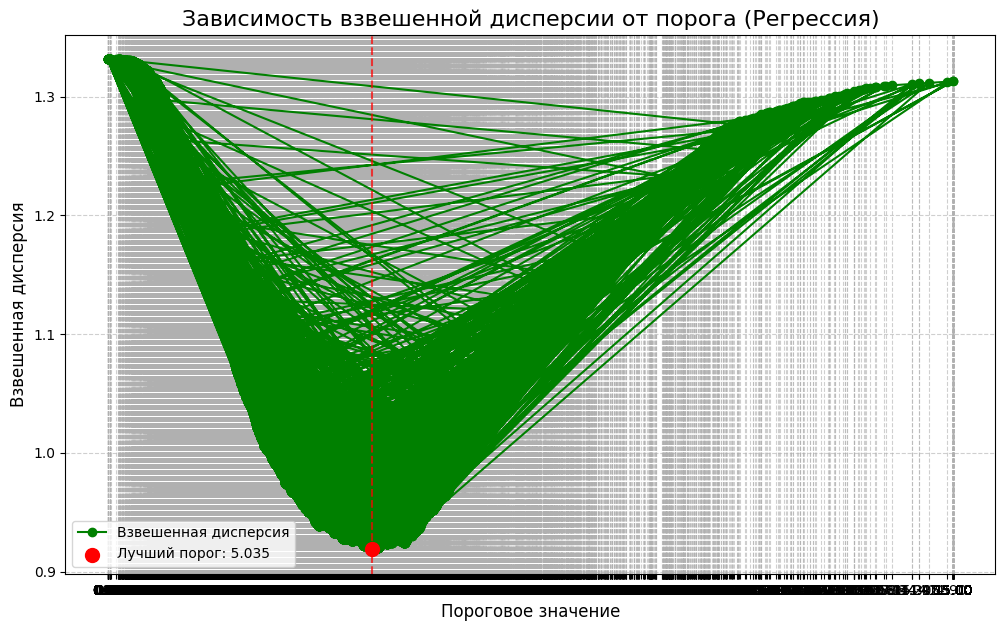

In [31]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
def calculate_weighted_disp(X, y, threshold):
    left_mask = X <= threshold
    right_mask = ~left_mask

    y_left, y_right = y[left_mask], y[right_mask]

    if len(y_left) == 0 or len(y_right) == 0:
        return float('inf')

    var_left = np.var(y_left)
    var_right = np.var(y_right)

    n_total = len(y)
    weighted_disp = (len(y_left) / n_total) * var_left + (len(y_right) / n_total) * var_right

    return weighted_disp


X_reg = X['MedInc']

thresholds_reg = [t for t in (X_reg[:-1] + X_reg[1:]) / 2 if not math.isnan(t)]
impurities_reg = [calculate_weighted_disp(X_reg, y, t) for t in thresholds_reg]

# Находим лучший порог
best_idx_reg = np.argmin(impurities_reg)
best_threshold_reg = thresholds_reg[best_idx_reg]
best_impurity_reg = impurities_reg[best_idx_reg]

# Построение графика
plt.figure(figsize=(12, 7))
plt.plot(thresholds_reg, impurities_reg, marker='o', linestyle='-', color='green', label='Взвешенная дисперсия')
plt.scatter(best_threshold_reg, best_impurity_reg, color='red', s=100, zorder=5, label=f'Лучший порог: {best_threshold_reg}')
plt.axvline(x=best_threshold_reg, color='red', linestyle='--', alpha=0.7)

# Оформление
plt.title('Зависимость взвешенной дисперсии от порога (Регрессия)', fontsize=16)
plt.xlabel('Пороговое значение', fontsize=12)
plt.ylabel('Взвешенная дисперсия', fontsize=12)
plt.xticks(thresholds_reg)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [32]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
print(f"Оптимальный порог: {best_threshold_reg}")
print(f"Минимальная взвешенная дисперсия: {best_impurity_reg:.4f}")

Оптимальный порог: 5.035
Минимальная взвешенная дисперсия: 0.9188


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data`, 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Посмотрим на распределение целевой переменной

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————